### Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

2024-03-28 16:26:29.069905: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Set random value

In [2]:
tf.random.set_seed(0)

In [3]:
# generate the input and output sequences
n_lookback = 180  # length of input sequences (lookback period)
n_forecast = 30  # length of output sequences (forecast period)

In [4]:
ticker = "BTC-USD"
start="2014-09-17"
end="2015-11-11"

In [5]:
fcast_range = pd.date_range(start=(pd.to_datetime(end)-pd.Timedelta(days=1)) + pd.Timedelta(days=1), periods=n_forecast+1)
fcast_start = pd.to_datetime(fcast_range.date[0] -pd.Timedelta(days=1))
fcast_end = fcast_range.date[-1].strftime("%Y-%m-%d")
fcast_end

'2015-12-11'

In [6]:
# download the data
df = yf.download(tickers=ticker, start=start, end=end)
y = df['Close'].fillna(method='ffill')
y = y.values.reshape(-1, 1)

[*********************100%%**********************]  1 of 1 completed
/var/folders/p3/911h6rnn6gg48kr5qy3v0xm40000gn/T/ipykernel_64248/3661750308.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = df['Close'].fillna(method='ffill')


In [7]:
benchmark = yf.download(tickers=ticker, start=fcast_start, end=fcast_end)
benchmark.rename(columns={"Close":"Benchmark"}, inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [8]:
# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

In [9]:
X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

In [10]:
X = np.array(X)

In [11]:
Y = np.array(Y)

In [15]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mse') <= 0.005): # Experiment with changing this value
      print("\nReached 0.002 so cancelling training!")
      self.model.stop_training = True

In [32]:
# fit the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

callbacks = myCallback()

model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mse"])
model.fit(X, Y, epochs=100, batch_size=32, callbacks=[callbacks])

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0690 - mse: 0.0692
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0443 - mse: 0.0444
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0207 - mse: 0.0208
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0116 - mse: 0.0116
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0088 - mse: 0.0088
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0086 - mse: 0.0086
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0081 - mse: 0.0081
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0078 - mse: 0.0078
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0076 - mse: 0.0076
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0075 - mse: 0.0075
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0074 - mse: 0.0074
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0074 - mse: 0.0073
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/ste

In [17]:
# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


In [18]:
# organize the results in a data frame
df_past = df[['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

/var/folders/p3/911h6rnn6gg48kr5qy3v0xm40000gn/T/ipykernel_64248/2242360039.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]


<Axes: title={'center': 'BTC-USD'}, xlabel='Date'>

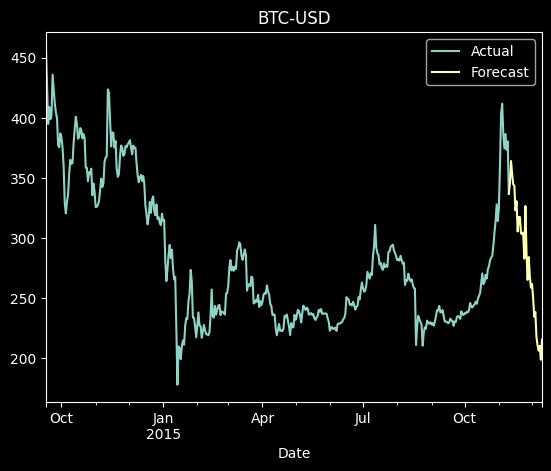

In [19]:
results = pd.concat([df_past, df_future]).set_index("Date")
# plot the results
plt.style.use('dark_background')
results.plot(title=ticker)

In [20]:
# Using plotly.express
import plotly.express as px
import plotly.io as pio
pio.templates
templates = ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']

In [21]:
plot_df = results.reset_index()
fig = px.line(plot_df, x="Date", y=results.columns,
          title=f"{ticker} {n_forecast} Forecast", #, {min(df["timestamp"].dt.date)}, {max(df["timestamp"].dt.date)}',
          template=templates[5])
#time.sleep(2)
fig.show()

In [22]:
# Using plotly.express
import plotly.express as px
import plotly.io as pio
pio.templates
templates = ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']

In [23]:
backtest_df = pd.merge(results.reset_index(), benchmark[["Benchmark"]].reset_index(), how="left", on="Date")

In [24]:
backtest_df.rename(columns={"Actual":"Train", "Benchmark":"True"}, inplace=True)

In [26]:
plot_df = backtest_df.reset_index()
fig = px.line(plot_df, x="Date", y=backtest_df.columns,
          title=f"{ticker} {n_forecast}day forecast, start={end}, forecast_end={fcast_end}", #, {min(df["timestamp"].dt.date)}, {max(df["timestamp"].dt.date)}',
          template=templates[5])
#time.sleep(2)
fig.show()